In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from WIreless_encoder.TXDataset import TXDataset
from WIreless_encoder.model import WirelessEncoder
import torch

img = cv2.imread('map/map_wireframe.png')

In [2]:
# Define the tokenizer
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

Using cache found in C:\Users\liuxi/.cache\torch\hub\huggingface_pytorch-transformers_main


In [3]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
# Create the dataset and dataloader

# Custom collate function for padding sequences
def custom_collate(batch):
    # Separate the input data (txnames) and labels
    txnames = [item[0] for item in batch]
    rssis = torch.tensor([item[1] for item in batch])
    rssis = torch.mul(rssis, -1)
    labels = torch.tensor([item[2] for item in batch])

    # Pad the sequences in txnames using pad_sequence
    padded_txnames = pad_sequence(txnames, batch_first=True)

    # Return the padded input data and labels
    return padded_txnames, rssis, labels

dataset = TXDataset('raw.csv', tokenizer)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate)

C:\Users\liuxi\Git Repo\WirelessDT\Source\WiTracingPy\RL\WIreless_encoder\TXDataset.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  self.data = self.data.groupby(['timestamp', 'x', 'y', 'z'])['rssi', 'tx'].agg(tolist).reset_index()


In [4]:
dataset.data

,timestamp,x,y,z,rssi,tx
0,1679538902693,475.289673,1482.590576,102.184547,"[-58, -70, -67, -66, -62, -58]","[TX_F1_Fountain, TX_F1_Instrument_4, TX_F1_Ins..."
1,1679538902759,476.011902,1483.588623,110.404449,"[-57, -72, -67, -67, -63, -58]","[TX_F1_Fountain, TX_F1_Instrument_4, TX_F1_Ins..."
2,1679538902794,486.526764,1481.530273,110.504608,"[-57, -69, -65, -65, -64, -59]","[TX_F1_Fountain, TX_F1_Instrument_4, TX_F1_Ins..."
3,1679538902828,496.901855,1474.441528,110.863770,"[-57, -71, -66, -67, -63, -60]","[TX_F1_Fountain, TX_F1_Instrument_4, TX_F1_Ins..."
4,1679538902860,506.555115,1461.993652,111.978073,"[-57, -70, -67, -66, -62, -60]","[TX_F1_Fountain, TX_F1_Instrument_4, TX_F1_Ins..."
...,...,...,...,...,...,...
6292,1679539160779,-693.878540,7103.696777,114.846436,"[-74, -73, -61, -65, -55, -58, -64]","[TX_F1_DressCode_17, TX_F1_DressCode_18, TX_F1..."
6293,1679539160804,-693.678711,7106.986816,114.070290,"[-73, -74, -62, -65, -54, -58, -64]","[TX_F1_DressCode_17, TX_F1_DressCode_18, TX_F1..."
6294,1679539160831,-693.429626,7110.733398,113.161743,"[-73, -75, -61, -65, -54, -58, -64]","[TX_F1_DressCode_17, TX_F1_DressCode_18, TX_F1..."
6295,1679539160858,-693.255554,7114.434570,112.097168,"[-73, -74, -62, -65, -54, -58, -64]","[TX_F1_DressCode_17, TX_F1_DressCode_18, TX_F1..."


In [13]:
import torch.nn as nn
import torch.optim as optim

# Create a neural network instance with 1000 possible words in the vocabulary, 16 embedding dimensions, and a hidden size of 64
model = WirelessEncoder(num_words=tokenizer.vocab_size, embedding_dim=16, hidden_size=64).to("cuda")

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 250

In [14]:
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0

    for idx, batch in enumerate(dataloader):
        # print("Batch: ", idx)
        TXName, RSSIs, label = batch
         # Convert the tensors to Float
        TXName = TXName.to("cuda")
        RSSIs = RSSIs.to("cuda")
        label = label.float().to("cuda")
        # Zero the gradients
        optimizer.zero_grad()

        model_input = TXName, RSSIs
        # Perform feedforward calculations and get the output
        output = model(model_input)

        # Define the target coordinates
        target = label

        # Compute the loss
        loss = criterion(output, target)

        # Perform backpropagation and update the parameters
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()
        losses.append(loss.item())

    # Print the average loss for the epoch
    print("Epoch %d, loss: %.3f" % (epoch + 1, running_loss / len(dataset)))

Epoch 1, loss: 13756.641
Epoch 2, loss: 32540.992
Epoch 3, loss: 48042.391
Epoch 4, loss: 104264.118
Epoch 5, loss: 33970.502
Epoch 6, loss: 104489.692
Epoch 7, loss: 59716.382
Epoch 8, loss: 111202.417
Epoch 9, loss: 40246.677
Epoch 10, loss: 52797.883
Epoch 11, loss: 72620.005
Epoch 12, loss: 74505.516
Epoch 13, loss: 69614.738
Epoch 14, loss: 84236.411
Epoch 15, loss: 81915.856
Epoch 16, loss: 76125.024
Epoch 17, loss: 69177.638
Epoch 18, loss: 59512.954
Epoch 19, loss: 46112.832
Epoch 20, loss: 37863.553
Epoch 21, loss: 30645.191
Epoch 22, loss: 23985.017
Epoch 23, loss: 23874.481
Epoch 24, loss: 21474.345
Epoch 25, loss: 19526.633
Epoch 26, loss: 15860.435
Epoch 27, loss: 13779.308
Epoch 28, loss: 13308.242
Epoch 29, loss: 11653.186
Epoch 30, loss: 9820.341
Epoch 31, loss: 8553.327
Epoch 32, loss: 7004.210
Epoch 33, loss: 5919.705
Epoch 34, loss: 5644.369
Epoch 35, loss: 5020.314
Epoch 36, loss: 4514.254
Epoch 37, loss: 3937.004
Epoch 38, loss: 3870.583
Epoch 39, loss: 3801.594
Ep

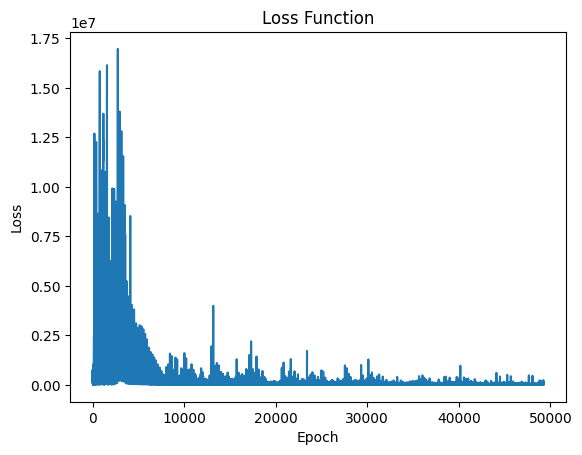

In [16]:
# plot the losses
plt.plot(losses)

# set the title and labels
plt.title("Loss Function")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# show the plot
plt.show()

In [21]:
with torch.no_grad():
    tx_name_ids = torch.tensor(tokenizer.encode("TX_F1_Fountain TX_F1_Instrument_4 TX_F1_Instrument_5 TX_F1_Instrument_6 TX_F1_Fountain2 TX_F1_Fountain3", padding='max_length', max_length=1024, add_special_tokens=True)).unsqueeze(0).to("cuda")
    tx_rssis = torch.tensor([ 58,  70,  67,  66,  62,  58, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]).unsqueeze(0).to("cuda")
    input = tx_name_ids, tx_rssis
    output = model(input)
    print(output)

tensor([[741.9784, 654.0448,  96.4897]], device='cuda:0')


In [22]:
labels_x = []
labels_y = []
names = []
rssis = []
for idx, batch in enumerate(dataloader):
    TXName, RSSIs, label = batch
    label = label.cpu().tolist()
    for la in label:
        labels_x.append(la[0])
        labels_y.append(la[1])
        names.append(TXName)
        rssis.append(RSSIs)

print(labels_x[:5])
print(labels_y[:5])
print(names[:5])
print(rssis[:5])

KeyboardInterrupt: 

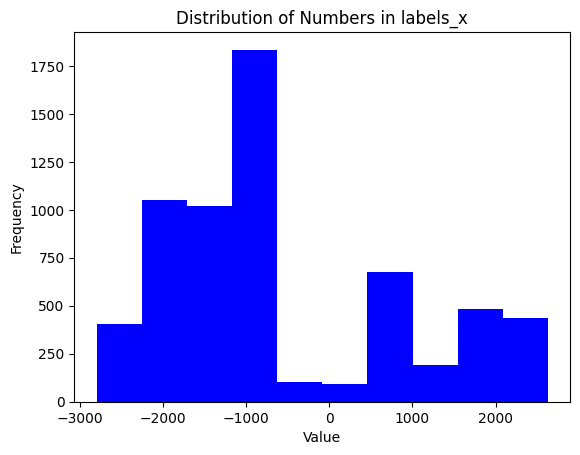

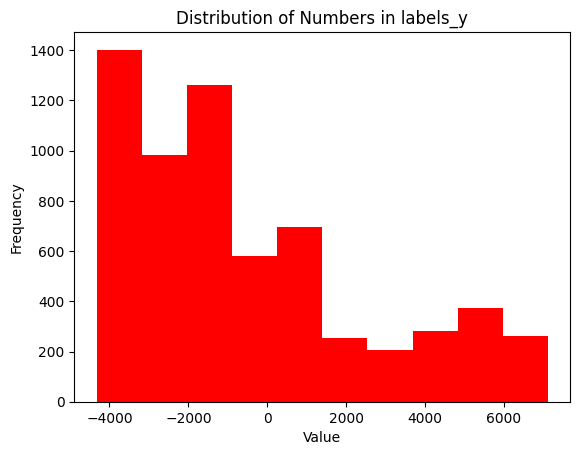

In [18]:
import matplotlib.pyplot as plt

# Create the first figure and axis
fig1, ax1 = plt.subplots()

# Plot the histogram for list1
ax1.hist(labels_x, bins=10, color='blue')

# Set the labels and title for the first figure
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Numbers in labels_x')

# Create the second figure and axis
fig2, ax2 = plt.subplots()

# Plot the histogram for list2
ax2.hist(labels_y, bins=10, color='red')

# Set the labels and title for the second figure
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Numbers in labels_y')

# Show both plots
plt.show()